# Лабораторная работа №5 "Применение сверточных нейронных сетей (бинарная классификация)"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab import files
from google.colab import drive

import zipfile
import pathlib
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [31]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/5/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.

In [5]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl


In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"presniatski","key":"285b0065530242871fcbdfefd4a841a4"}'}

In [ ]:
!chmod 600 kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle

In [9]:
!kaggle competitions download -c dogs-vs-cats

 99% 807M/812M [00:19<00:00, 144MB/s]
100% 812M/812M [00:19<00:00, 44.6MB/s]


In [ ]:
!unzip dogs-vs-cats.zip
!cp train.zip /content/drive/'My Drive'/'Colab Notebooks'/5/
!cp test1.zip /content/drive/'My Drive'/'Colab Notebooks'/5/

In [ ]:
with zipfile.ZipFile(f'{DRIVE_DIR}train.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

train_data_dir = pathlib.Path('./data/train/')

In [4]:
ALL_PATHS = sorted([str(item) for item in train_data_dir.glob('*')])
CATS_NUMBER = len(list(train_data_dir.glob('cat*')))
DOGS_NUMBER = len(list(train_data_dir.glob('dog*')))
LABELS = np.array([0] * CATS_NUMBER + [1] * DOGS_NUMBER)

print(f'All images number: {len(ALL_PATHS)}')
print(f'Cats number: {CATS_NUMBER}')
print(f'Dogs number: {DOGS_NUMBER}')

All images number: 25000
Cats number: 12500
Dogs number: 12500


In [ ]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(ALL_PATHS, LABELS, test_size=0.4)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5)

total_train = len(train_paths)
total_valid = len(valid_paths)
total_test = len(test_paths)

In [6]:
print(f'Train items number: {total_train}')
print(f'Valid items number: {total_valid}')
print(f'Test items number: {total_test}')

Train items number: 15000
Valid items number: 5000
Test items number: 5000


In [ ]:
def load_files_to_dirs(paths, labels, folder):
    path = pathlib.Path(folder)
    if path.is_dir():
        shutil.rmtree(str(path))

    for i in set(labels):
        path = pathlib.Path(f'{folder}/{i}/')
        path.mkdir(parents=True, exist_ok=True)

    for i, p in enumerate(paths):
        src = pathlib.Path(p)
        dst = pathlib.Path(f'{folder}/{labels[i]}/{src.name}')
        shutil.copyfile(str(src), str(dst))

In [ ]:
TRAIN_DATA_DIR = 'train_set'
VALID_DATA_DIR = 'valid_set'
TEST_DATA_DIR = 'test_set'

In [ ]:
load_files_to_dirs(train_paths, train_labels, folder=TRAIN_DATA_DIR)
load_files_to_dirs(valid_paths, valid_labels, folder=VALID_DATA_DIR)
load_files_to_dirs(test_paths, test_labels, folder=TEST_DATA_DIR)

In [ ]:
BATCH_SIZE = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
def create_generator(directory, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image_gen = ImageDataGenerator(rescale=1./255)
    data_gen = image_gen.flow_from_directory(
        batch_size=batch_size,
        directory=directory,
        target_size=target_size,
        class_mode='binary',
    )
    return data_gen

In [13]:
train_data_gen = create_generator(TRAIN_DATA_DIR)
valid_data_gen = create_generator(VALID_DATA_DIR)
test_data_gen = create_generator(TEST_DATA_DIR)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
def show_images(data_gen):
    image_batch, label_batch = next(data_gen)
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n, :, :, :])
        plt.title('dog' if label_batch[n] else 'cat')
        plt.axis('off')

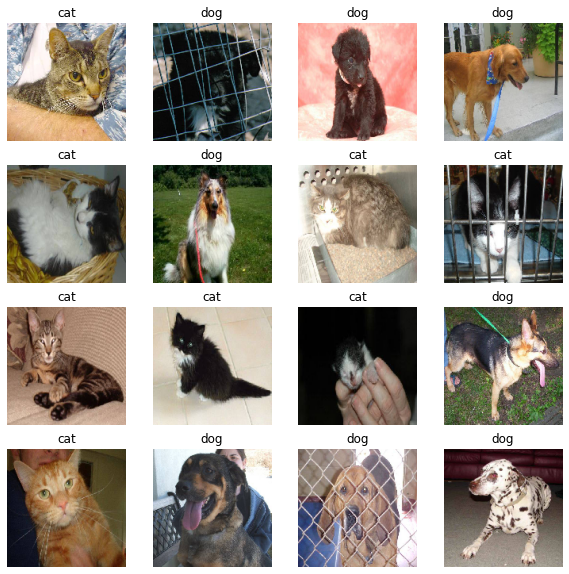

In [14]:
show_images(train_data_gen)

### Задание 2.
Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?

In [ ]:
def build_model():
    model = keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)       

In [ ]:
def show_history(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [17]:
EPOCHS = 20

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)
checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_dogs_cats_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    train_data_gen, 
    epochs=EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)


Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.6748
Epoch 00001: val_accuracy improved from -inf to 0.52684, saving model to /content/drive/My Drive/Colab Notebooks/5/cnn_dogs_cats_weights.h5
117/117 [==============================] - 40s 343ms/step - loss: 0.6967 - accuracy: 0.6748 - val_loss: 0.9432 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7557
Epoch 00002: val_accuracy did not improve from 0.52684
117/117 [==============================] - 35s 297ms/step - loss: 0.5064 - accuracy: 0.7557 - val_loss: 1.8532 - val_accuracy: 0.4971 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.7914
Epoch 00003: val_accuracy did not improve from 0.52684
117/117 [==============================] - 36s 308ms/step - loss: 0.4451 - accuracy: 0.7914 - val_loss: 1.8565 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 4/20
117/117 [=

In [18]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_dogs_cats_weights.h5')
eval_model.evaluate(test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

39/39 [==============================] - 7s 179ms/step - loss: 0.4270 - accuracy: 0.8720


[0.4269930124282837, 0.871995210647583]

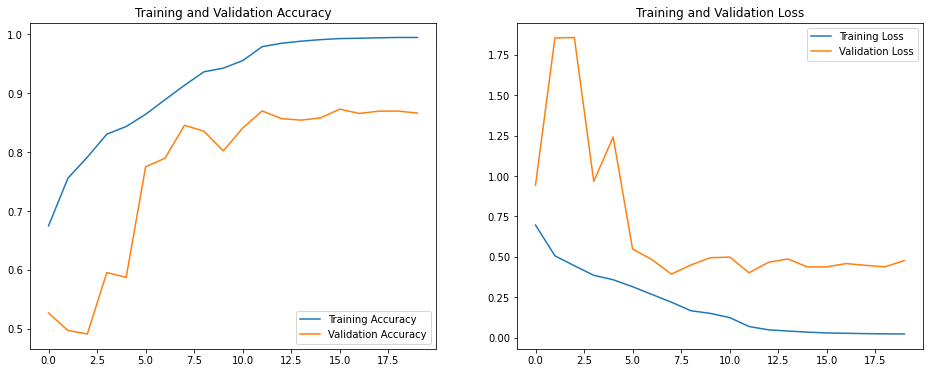

In [19]:
show_history(history)

На контрольной выборке получено достаточно неплохое качество: точность составила 87.2%. На графиках можно видеть, как изменяется точность и ошибка: на обучающей выборке точность больше, а ошибка меньше, чем на валидационной выборке.

Также можно заметить, что после 10-ой эпохи показатели на валидационной выборке остаются на приблизительно одном уровне. Это говорит о том, что модель начинает переобучаться. Чтобы этого избежать, применим дополнение данных.

### Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора?

In [ ]:
def create_augmented_generator(directory, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=.15,
        height_shift_range=.15,
        horizontal_flip=True,
        brightness_range=(0.6, 1.4),
        zoom_range=0.2
    )
    data_gen = image_gen.flow_from_directory(
        batch_size=batch_size,
        directory=directory,
        target_size=target_size,
        class_mode='binary',
    )
    return data_gen

In [15]:
train_augmented_data_gen = create_augmented_generator(TRAIN_DATA_DIR)

Found 15000 images belonging to 2 classes.


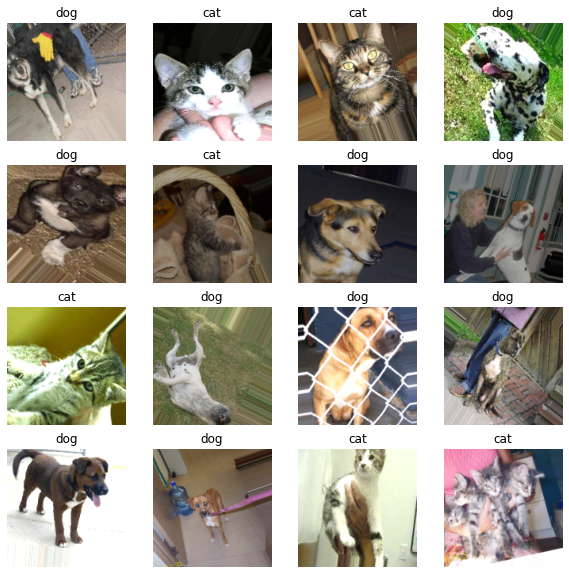

In [22]:
show_images(train_augmented_data_gen)

In [27]:
EPOCHS = 20

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_augmented_dogs_cats_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    train_augmented_data_gen, 
    epochs=EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.5937
Epoch 00001: val_accuracy improved from -inf to 0.49979, saving model to /content/drive/My Drive/Colab Notebooks/5/cnn_augmented_dogs_cats_weights.h5
117/117 [==============================] - 88s 755ms/step - loss: 0.8360 - accuracy: 0.5937 - val_loss: 1.9171 - val_accuracy: 0.4998 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.6313
Epoch 00002: val_accuracy improved from 0.49979 to 0.52360, saving model to /content/drive/My Drive/Colab Notebooks/5/cnn_augmented_dogs_cats_weights.h5
117/117 [==============================] - 85s 729ms/step - loss: 0.6962 - accuracy: 0.6313 - val_loss: 0.8558 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6630
Epoch 00003: val_accuracy improved from 0.52360 to 0.54782, saving model to /content/drive/My Drive/Colab Notebooks

In [28]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_augmented_dogs_cats_weights.h5')
eval_model.evaluate(test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

39/39 [==============================] - 8s 206ms/step - loss: 0.3936 - accuracy: 0.8432


[0.39355596899986267, 0.843185544013977]

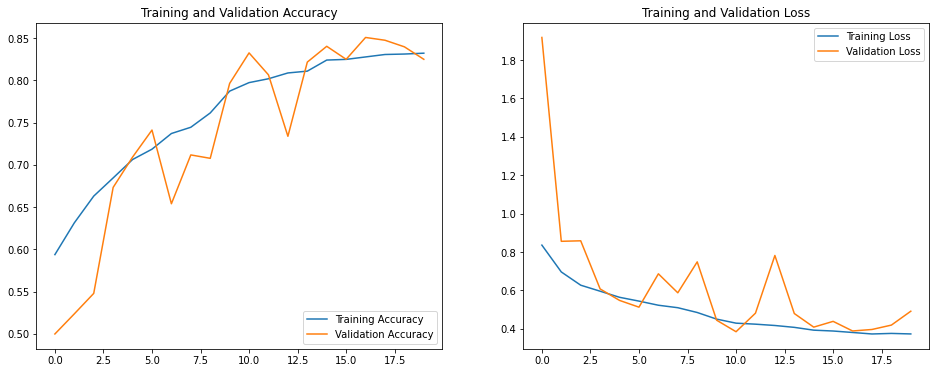

In [29]:
show_history(history)

Модель показала чуть хуже результаты: точность упала на 2.9% и составила 84.3%. Зато ошибка стала меньше.

Судя по графикам можно сказать, что нам удалось избежать переобучения, и, вероятно, если бы мы продлили обучение на большее количество эпох, то результаты были бы ещё лучше.

### Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора?
Какой максимальный результат удалось получить на сайте Kaggle? Почему?

В рамках исследования выберем модель VGG16.
Загрузим модель из библиотеки keras, обученную на датасете imagenet, не включая слои классификатора. Затем запретим обучаться слоям этой нейронной сети и посмотрим её структуру.

In [16]:
vgg16_net = keras.applications.VGG16(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                                     include_top=False,
                                     weights="imagenet")
vgg16_net.trainable = False
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Добавим свои слои классификации - полносвязный слой с 512 нейронами и выходной слой с одним нейроном.

In [17]:
model = keras.models.Sequential()
model.add(vgg16_net)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
EPOCHS = 20

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_vgg16_dogs_cats_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    train_augmented_data_gen, 
    epochs=EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.7467
Epoch 00001: val_accuracy improved from -inf to 0.88301, saving model to /content/drive/My Drive/Colab Notebooks/5/cnn_vgg16_dogs_cats_weights.h5
117/117 [==============================] - 94s 801ms/step - loss: 0.6085 - accuracy: 0.7467 - val_loss: 0.2747 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8356
Epoch 00002: val_accuracy improved from 0.88301 to 0.89388, saving model to /content/drive/My Drive/Colab Notebooks/5/cnn_vgg16_dogs_cats_weights.h5
117/117 [==============================] - 92s 790ms/step - loss: 0.3673 - accuracy: 0.8356 - val_loss: 0.2453 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8487
Epoch 00003: val_accuracy did not improve from 0.89388
117/117 [==============================] - 91s 774ms/step - loss: 0.

In [19]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_vgg16_dogs_cats_weights.h5')
eval_model.evaluate(test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

39/39 [==============================] - 20s 506ms/step - loss: 0.2095 - accuracy: 0.9133


[0.2095375806093216, 0.9132612347602844]

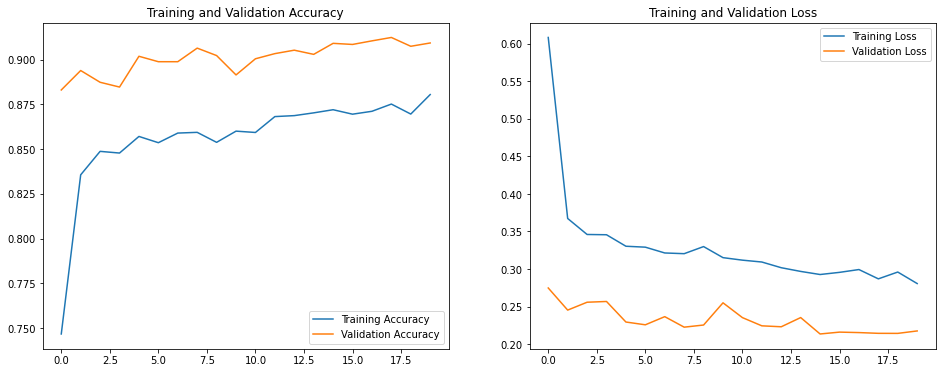

In [22]:
show_history(history)

Применив передаточное обучение, точность классификатора увеличилась: она составила 91.3%, т.е. на 4.1% лучше предыдущей лучшей точности. Это показывает нам то, что предобученные модели можно успешно использовать для решения своих задач, потому что, как правило, они обучаются в течение значительно большего количества времени на гораздо большем наборе данных, которые могли в некоторой степени пересекаться с нашими данными, плюс имеют хорошую архитектуру.

Стоит заметить что на графиках точность на валидационной выборке выше чем на обучающей. Это связано с тем, что данные из обучающей выборки подвергались изменениям.

Опробуем обученную модель на тестовой выборке с сайте kaggle и посмотрим некоторые результаты.

In [ ]:
with zipfile.ZipFile(f'{DRIVE_DIR}test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/test/')

test1_data_dir = pathlib.Path('./data/test/')

In [ ]:
def create_test_generator(directory, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image_gen = ImageDataGenerator(rescale=1./255)
    data_gen = image_gen.flow_from_directory(
        batch_size=batch_size,
        directory=directory,
        target_size=target_size,
        class_mode=None,
        shuffle=False,
    )
    return data_gen

In [87]:
test1_data_gen = create_test_generator(str(test1_data_dir))
first_batch = next(iter(test1_data_gen))

Found 12500 images belonging to 1 classes.


In [ ]:
test_model = keras.models.load_model(f'{DRIVE_DIR}cnn_vgg16_dogs_cats_weights.h5')
preds = test_model.predict(first_batch)

In [ ]:
real_preds = np.where(preds >= 0.5, 'dog', 'cat').flatten()

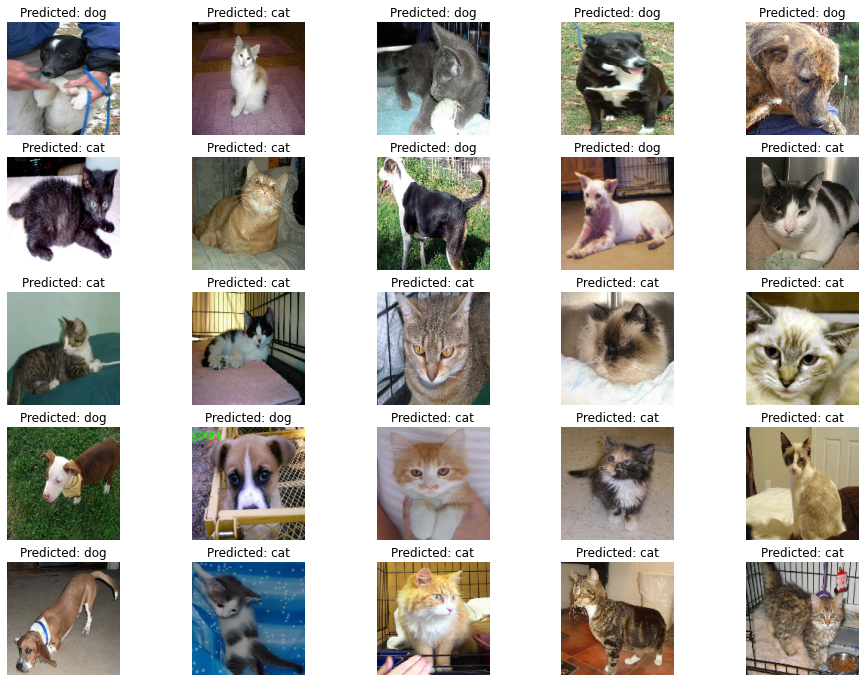

In [92]:
fig = plt.figure(figsize=(16, 12))

for i in range(1, 26):
    ax = fig.add_subplot(5, 5, i)
    ax.set_title(f'Predicted: {real_preds[i - 1]}')
    ax.set_axis_off()
    plt.imshow(first_batch[i - 1])

plt.show()

Как видим, результат получился довольно неплохой: из 25 картинок только одна предсказана неверно.

А теперь попробуем протестировать модель на собственных фотографиях.

In [ ]:
import cv2

data_dir = pathlib.Path(DRIVE_DIR)

X_real = []
for path in data_dir.glob('*.jpg'):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    X_real.append(img)

X_real = np.array(X_real)

In [ ]:
test_model = keras.models.load_model(f'{DRIVE_DIR}cnn_vgg16_dogs_cats_weights.h5')
preds = test_model.predict(X_real)
real_preds = np.where(preds >= 0.5, 'dog', 'cat').flatten()

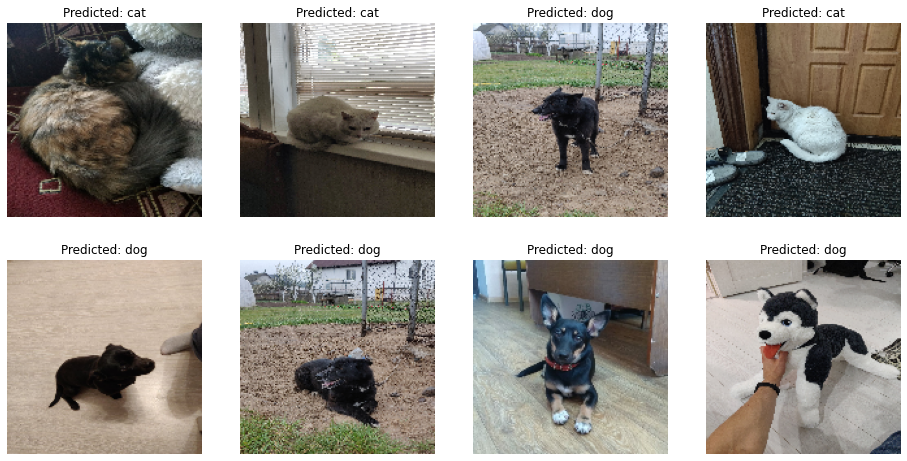

In [37]:
fig = plt.figure(figsize=(16, 8))

for i in range(1, 9):
    ax = fig.add_subplot(2, 4, i)
    ax.set_title(f'Predicted: {real_preds[i - 1]}')
    ax.set_axis_off()
    plt.imshow(X_real[i - 1])

plt.show()